In [1]:
import os
os.chdir('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gedvi_dir = '/home/xlv0877/proj_home/dl/models/mixscale/n_1308/lightning_logs/version_4/'
scanvi_dir = '/home/xlv0877/proj_home/dl/models/mixscale/n_1326/lightning_logs/version_3'
scanvi_raw_dir = '/home/xlv0877/proj_home/dl/models/raw/scanvi/n_2000/lightning_logs/version_1'

In [3]:
g_report = pd.read_csv(os.path.join(gedvi_dir, 'report.csv'), index_col=0)
s_report = pd.read_csv(os.path.join(scanvi_dir, 'report.csv'), index_col=0)
raw_s_report = pd.read_csv(os.path.join(scanvi_raw_dir, 'report.csv'), index_col=0)

In [4]:
g_report['model'] = 'gedVAE + mixscale'
s_report['model'] = 'scanVAE + mixscale'
raw_s_report['model'] = 'scanVAE'
report = pd.concat([g_report, s_report, raw_s_report], axis=0)

In [5]:
report['model'] = pd.Categorical(report['model'], categories=report.groupby('model')['f1-score'].mean().sort_values().index.values)

### F1-scores overall

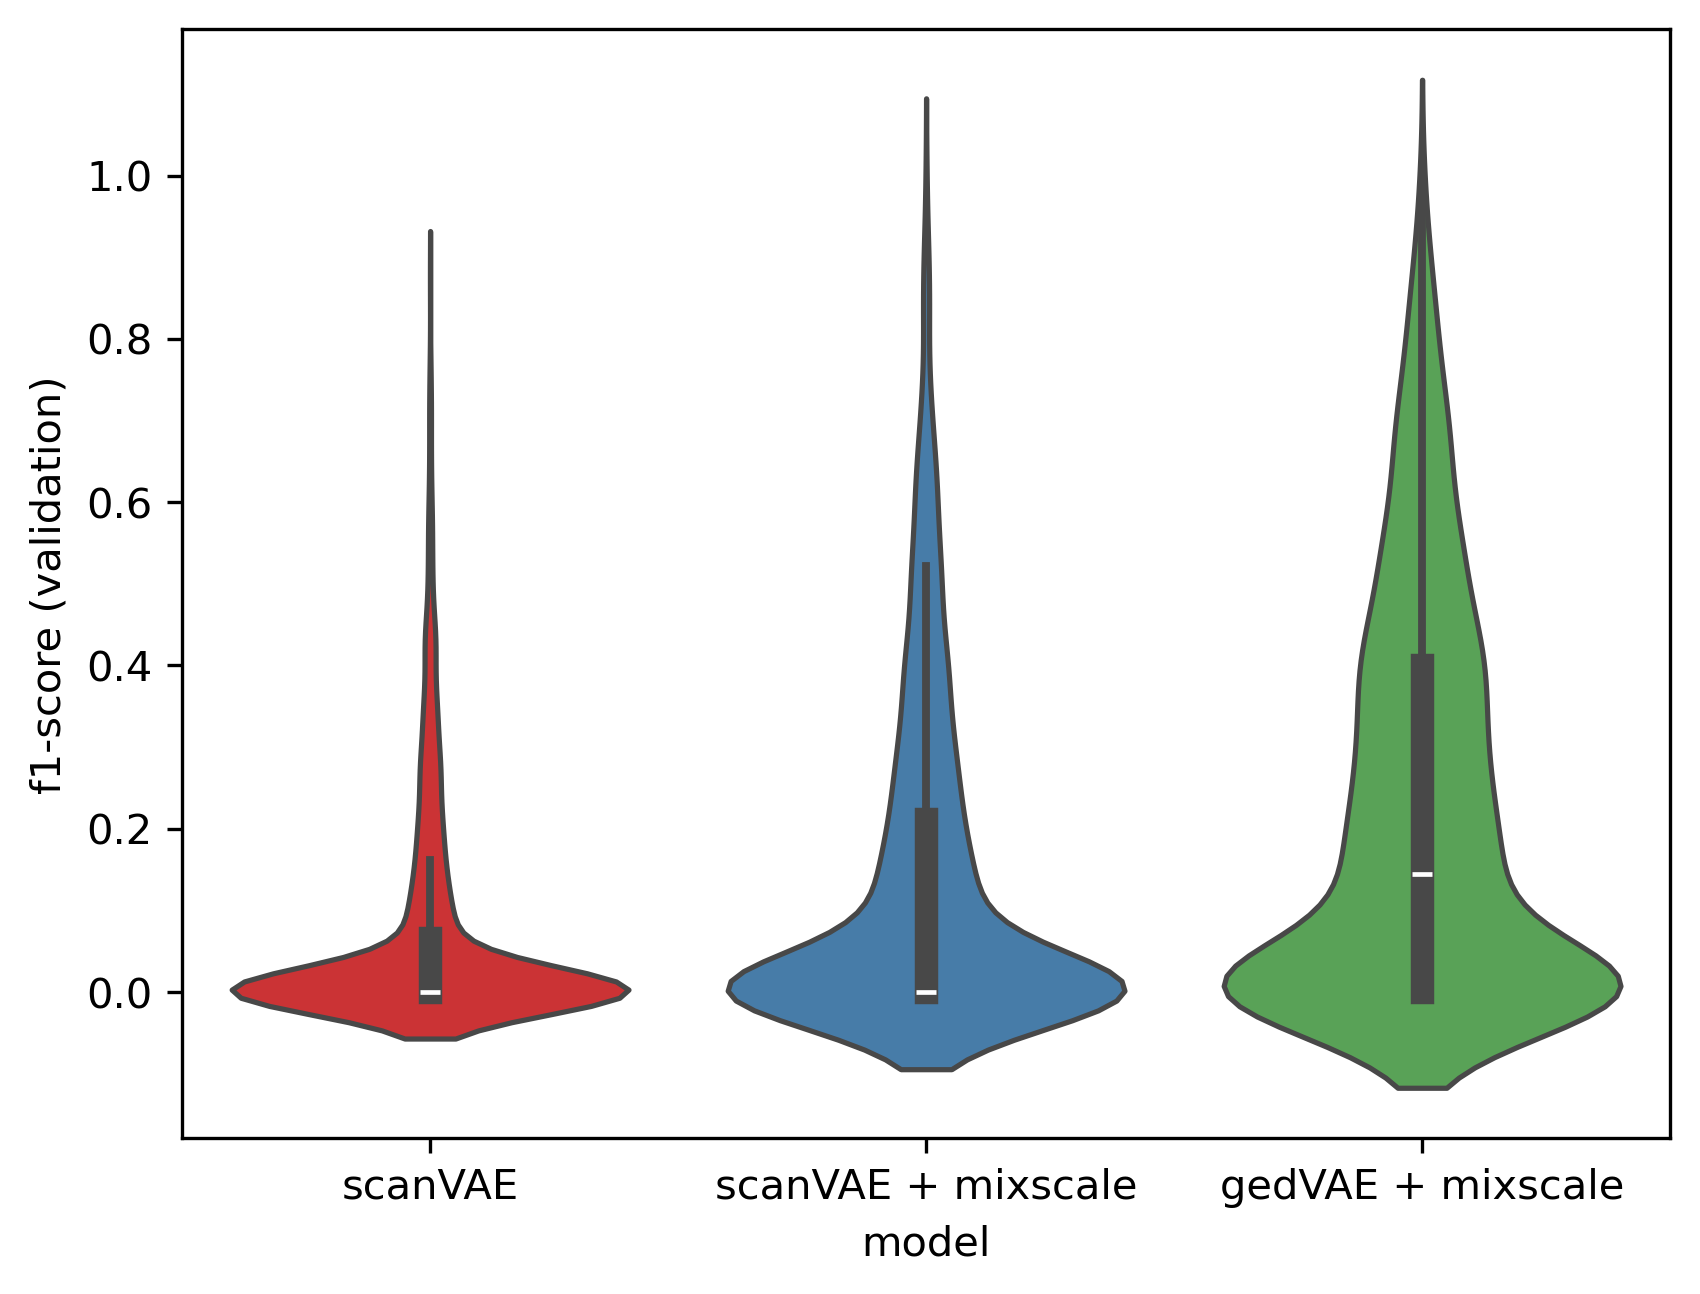

In [14]:
fig = plt.figure(dpi=300)

ax = sns.violinplot(report, x='model', y='f1-score', hue='model', palette='Set1')
plt.ylabel('f1-score (validation)')
plt.show()

In [6]:
# summary
g_summary = pd.read_csv(os.path.join(gedvi_dir, 'summary.csv'))
s_summary = pd.read_csv(os.path.join(scanvi_dir, 'summary.csv'))
r_summary = pd.read_csv(os.path.join(scanvi_raw_dir, 'summary.csv'))
g_summary['model'] = 'gedVAE + mixscale'
s_summary['model'] = 'scanVAE + mixscale'
r_summary['model'] = 'scanVAE'
summary = pd.concat([g_summary, s_summary, r_summary])

In [7]:
macro_summary = summary[summary.iloc[:,0]=='macro avg'].copy()

In [8]:
macro_summary['model'] = pd.Categorical(macro_summary['model'], categories=macro_summary.sort_values('f1-score')['model'].unique())

### Macro f1-scores

Text(0, 0.5, 'f1-score (macro average)')

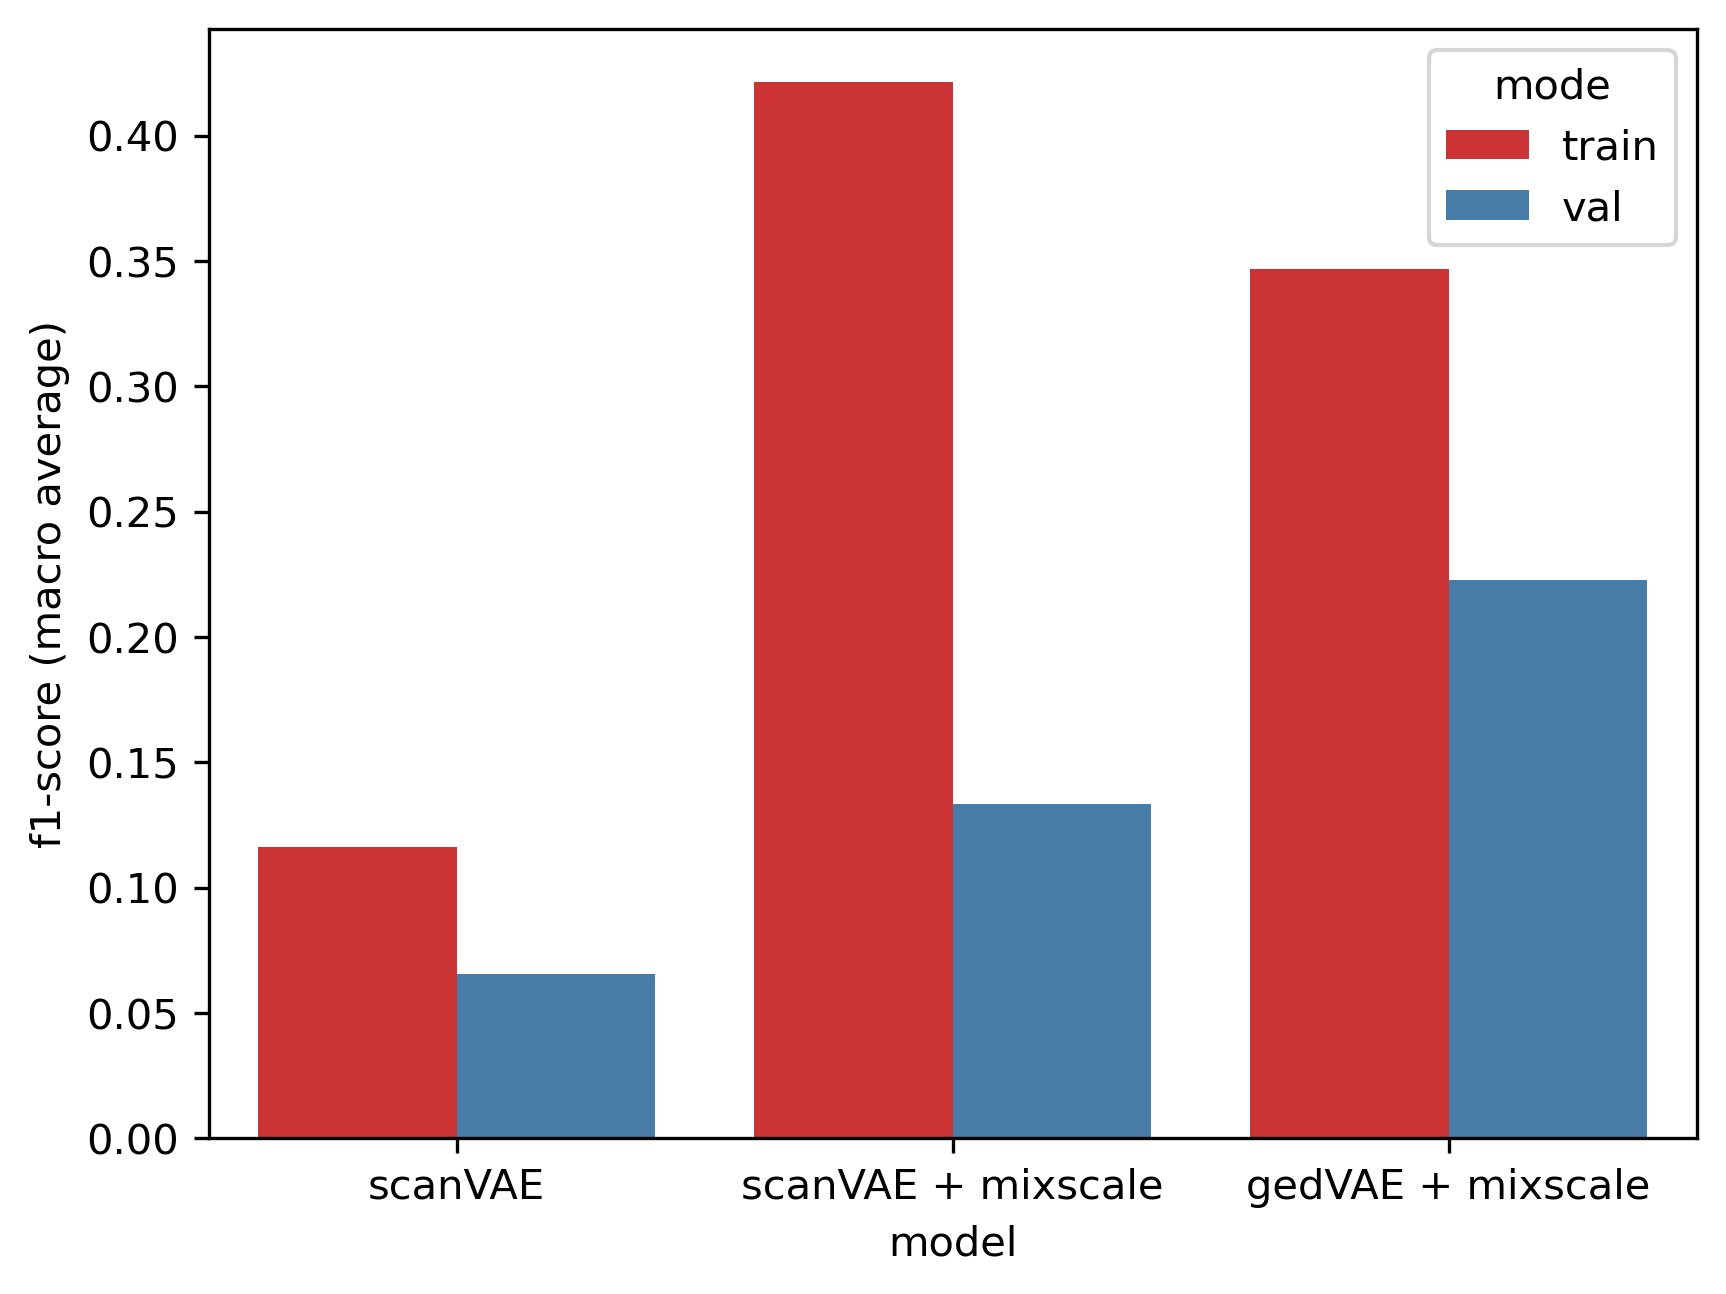

In [29]:
fig = plt.figure(dpi=300)
ax = sns.barplot(macro_summary, x='model', y='f1-score', hue='mode', palette='Set1')
plt.ylabel('f1-score (macro average)')

### AUC / AUROC curves --> TODO: requires direct model prediction

In [19]:
# Load latent spaces
import scanpy as sc
import anndata as ad

data_dirs = [gedvi_dir, scanvi_dir, scanvi_raw_dir]
model_keys = ['gedVI + mixscale', 'scanVI + mixscale', 'scanVI']

latent = []
for m, d in zip(model_keys, data_dirs):
    print(f'Reading: {d}')
    adata = sc.read(os.path.join(d, 'latent.h5ad'))
    adata.obs['model'] = m
    latent.append(adata)
latent = ad.concat(latent, axis=0)

Reading: /home/xlv0877/proj_home/dl/models/mixscale/n_1308/lightning_logs/version_4/
Reading: /home/xlv0877/proj_home/dl/models/mixscale/n_1326/lightning_logs/version_3
Reading: /home/xlv0877/proj_home/dl/models/raw/scanvi/n_2000/lightning_logs/version_1


/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### F1-support correlation

In [38]:
report['model'] = pd.Categorical(report['model'], categories=report['model'].cat.categories[::-1])

In [51]:
val_split = 0.1
report['log_support_total'] = np.log10(report['support'] * val_split * 100)

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


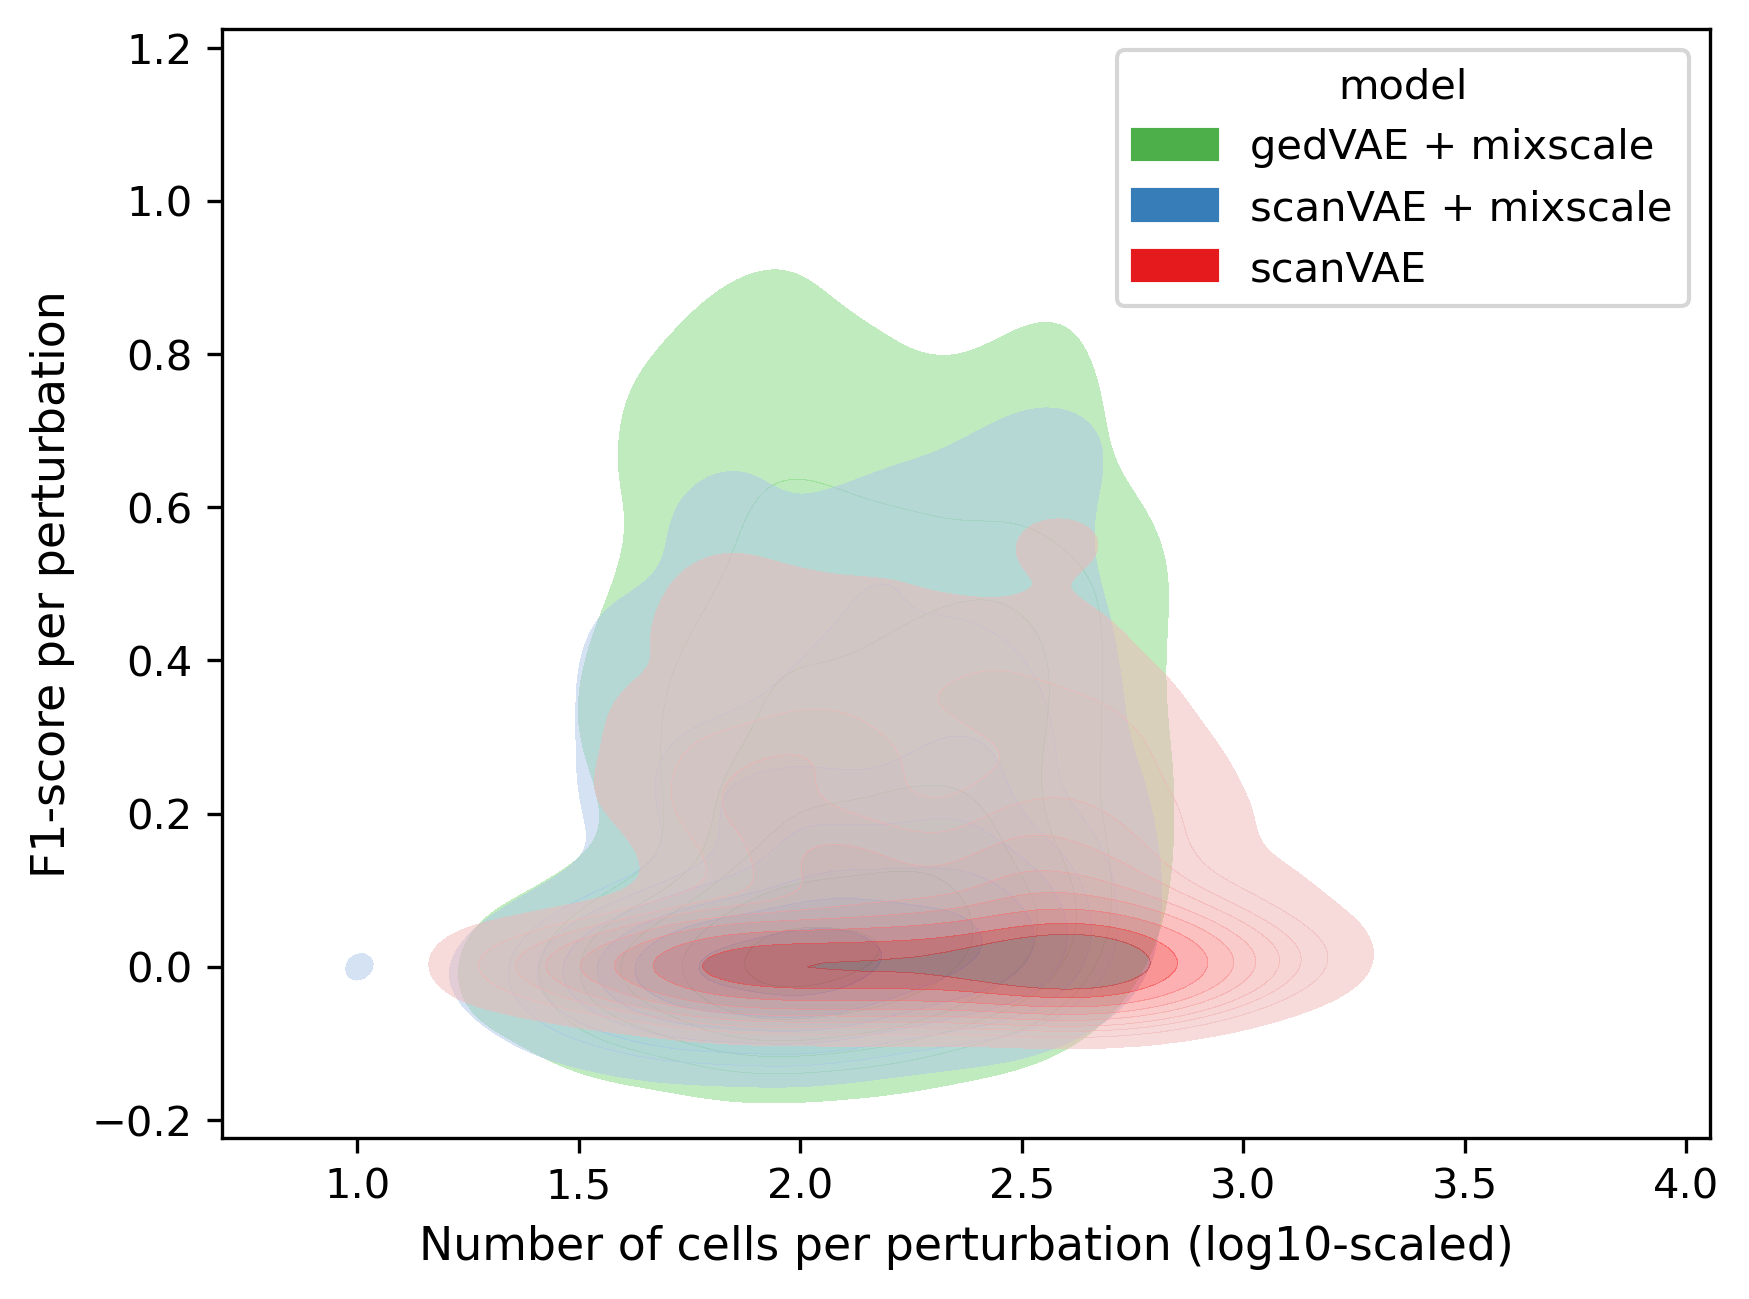

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(dpi=300)
pal = sns.color_palette('Set1', n_colors=report['model'].nunique())
pal.reverse()
ax = sns.kdeplot(report.reset_index(drop=True), y='f1-score', x='log_support_total', hue='model',
                 fill=True, alpha=0.5, palette=pal)
ax.set_ylabel('F1-score per perturbation', fontsize=11)
ax.set_xlabel('Number of cells per perturbation (log10-scaled)', fontsize=11)
ax.tick_params(axis='both', labelsize=10)
plt.show()

In [67]:
import scanpy as sc
s_latent = sc.read(os.path.join(scanvi_dir, 'latent.h5ad'), backed='r')
g_latent = sc.read(os.path.join(gedvi_dir, 'latent.h5ad'), backed='r')
r_latent = sc.read(os.path.join(scanvi_raw_dir, 'latent.h5ad'), backed='r')

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

### scanVI

Text(0.5, 1.0, 'Confusion Matrix')

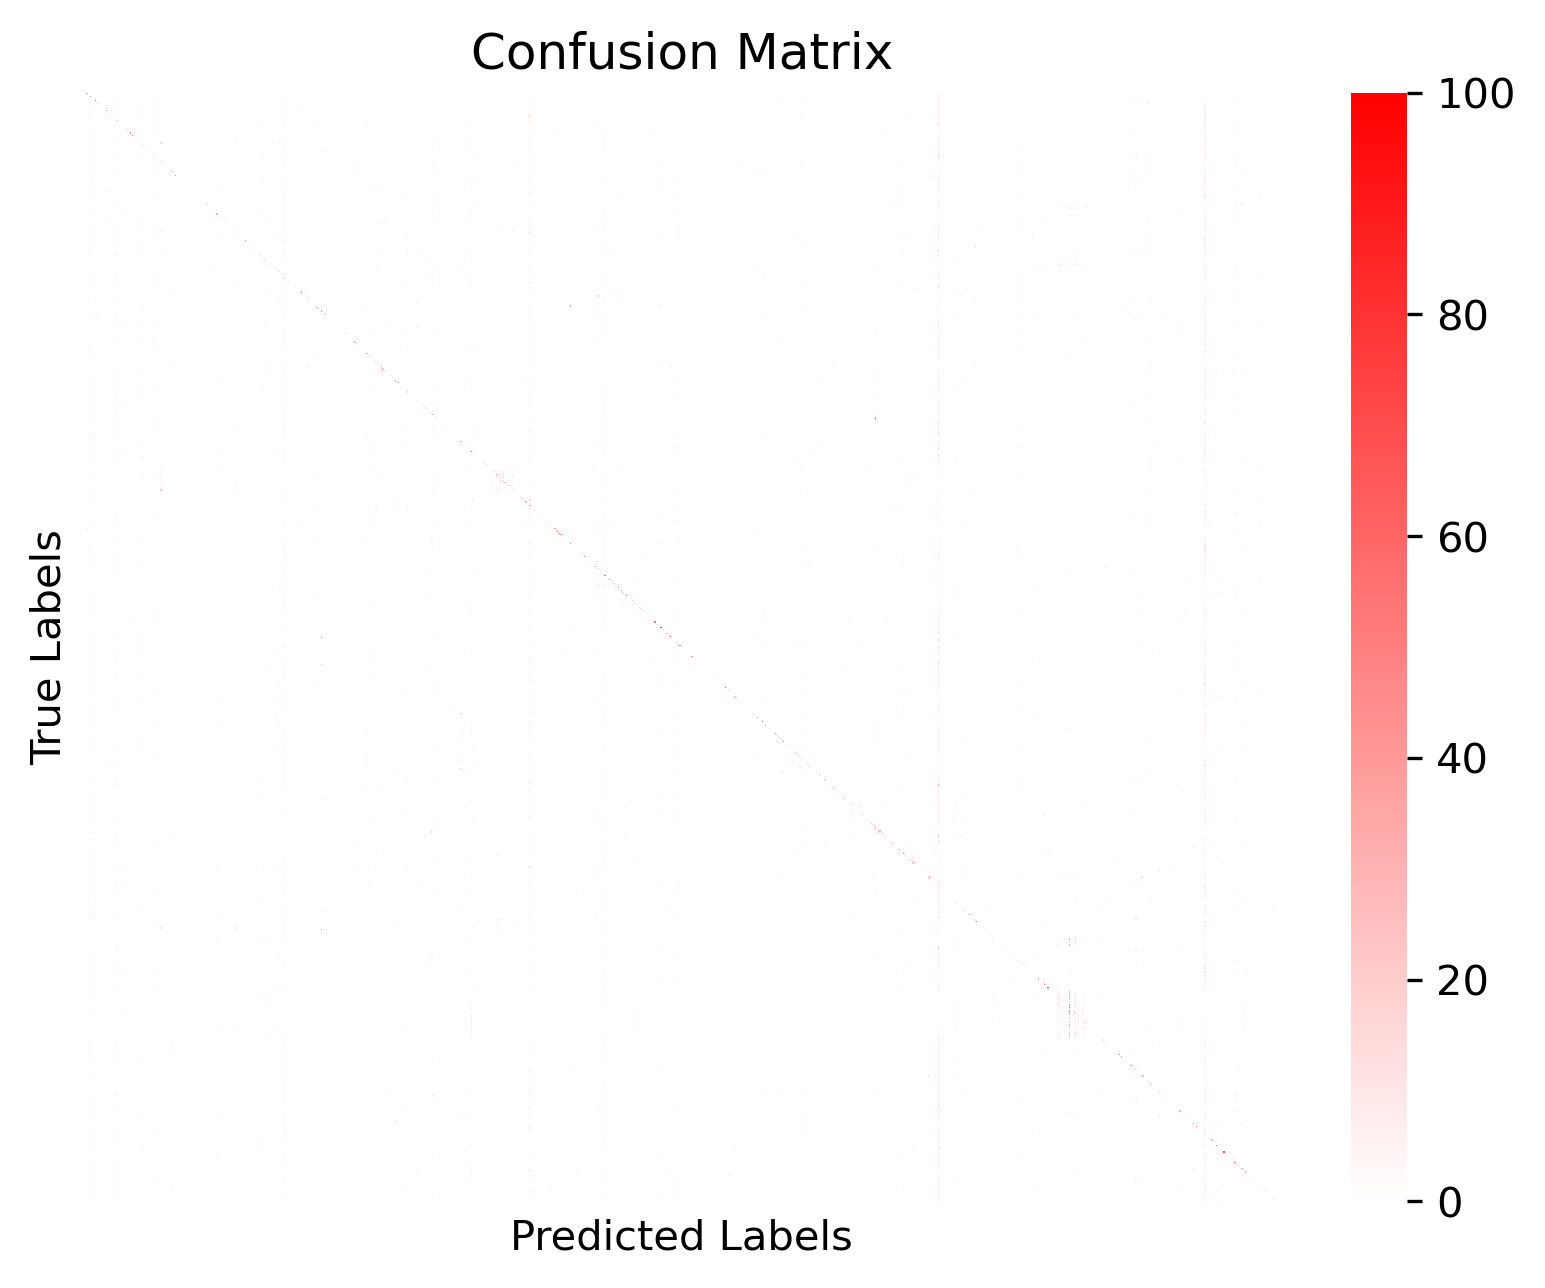

In [87]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix

target = r_latent
val_latent = target[target.obs['mode']=='val']
val_latent.obs.sort_values('pathway', inplace=True)

y_true = val_latent.obs.perturbation.astype(str)
y_pred = val_latent.obs.scanvi_predictions.str.split(';').str[-1]

u_y = y_true.unique()
y_true = pd.Categorical(y_true, categories=u_y)
y_pred = pd.Categorical(y_pred, categories=y_pred.unique())
# Select class labels
class_labels = pd.Categorical(u_y, categories=u_y)
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_labels)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


fig = plt.figure(dpi=300)

# Define a custom colormap from white to dodgerblue
white_to_blue = LinearSegmentedColormap.from_list(
    "white_to_blue",
    ["#ffffff", "red"]  # start at true white
)

# Plot the heatmap
sns.heatmap(
    cm_percentage,
    xticklabels=class_labels,
    yticklabels=class_labels,
    cmap=white_to_blue,
    vmin=0,
    vmax=100
)
plt.xlabel('Predicted Labels')
plt.xticks([])
plt.yticks([])
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

### gedVI + mixscale

Text(0.5, 1.0, 'Confusion Matrix')

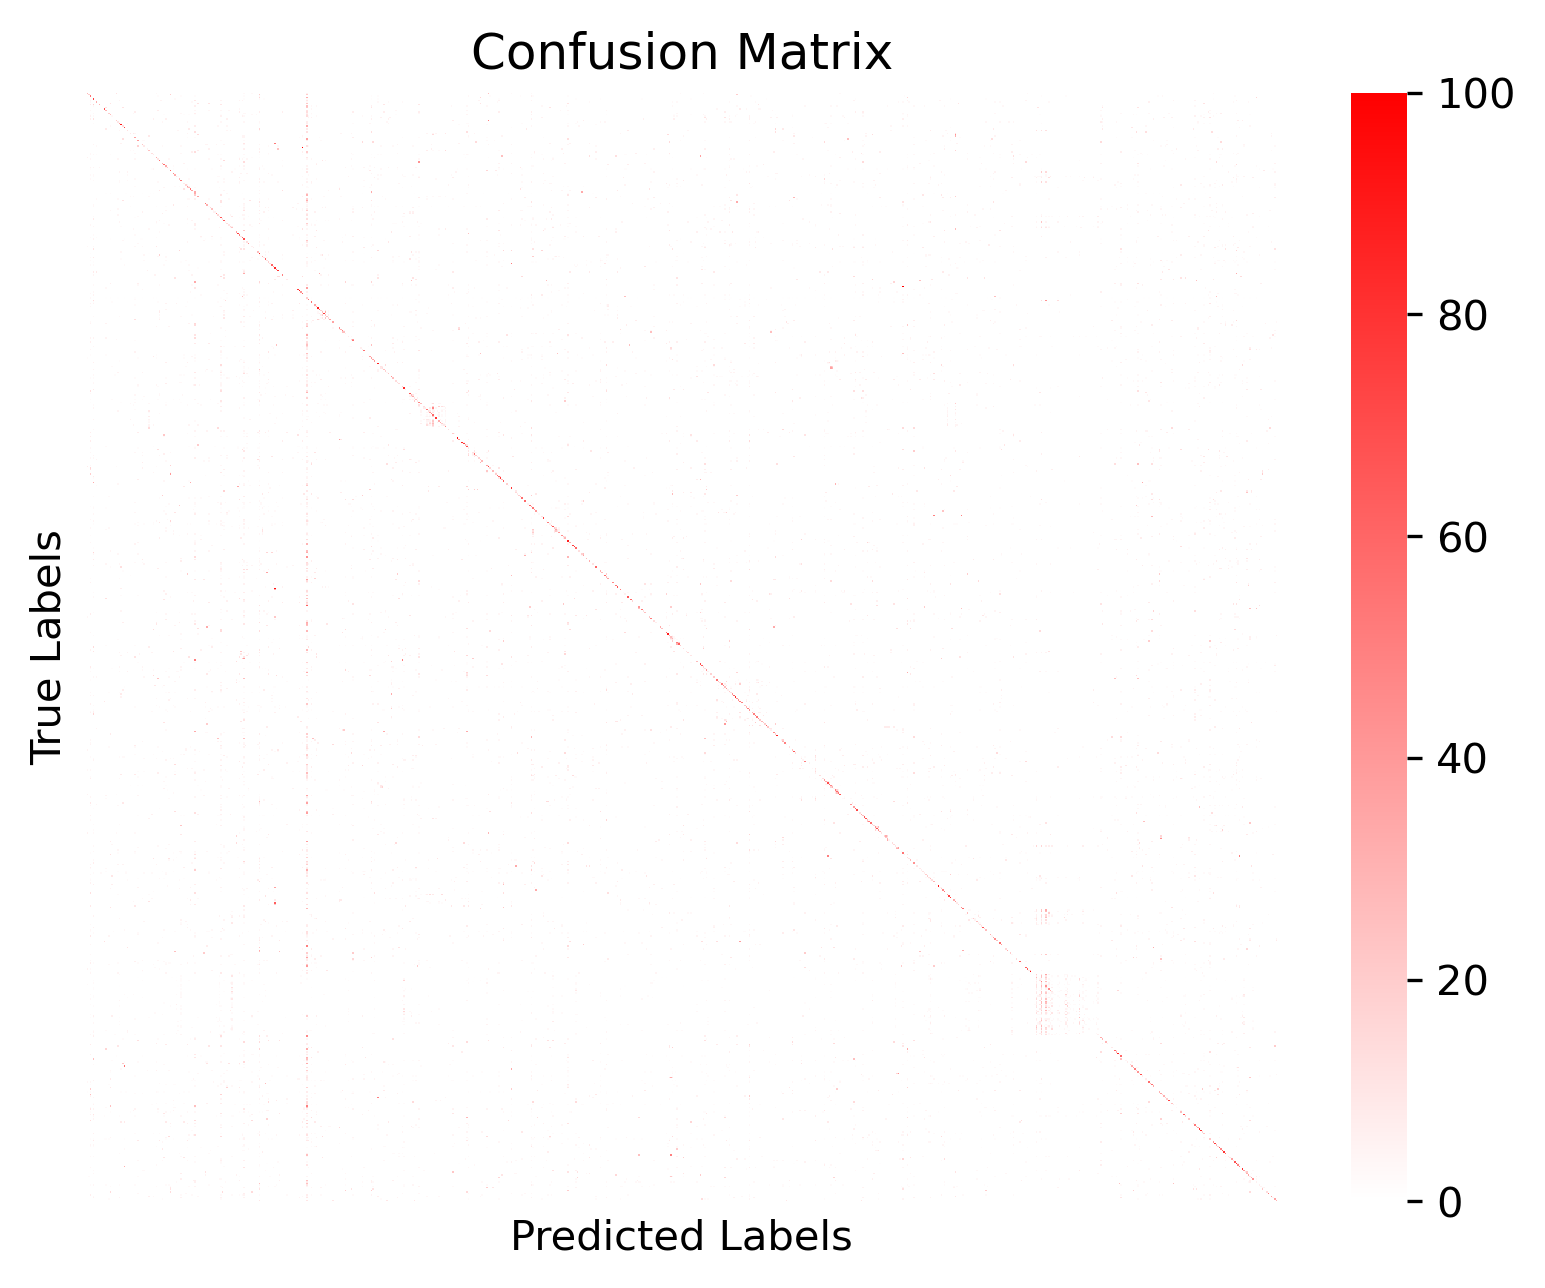

In [89]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix

target = g_latent
val_latent = target[target.obs['mode']=='val']
val_latent.obs.sort_values('pathway', inplace=True)

y_true = val_latent.obs.perturbation.astype(str)
y_pred = val_latent.obs.scanvi_predictions.str.split(';').str[-1]

u_y = y_true.unique()
y_true = pd.Categorical(y_true, categories=u_y)
y_pred = pd.Categorical(y_pred, categories=y_pred.unique())
# Select class labels
class_labels = pd.Categorical(u_y, categories=u_y)
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_labels)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


fig = plt.figure(dpi=300)

# Define a custom colormap from white to dodgerblue
white_to_blue = LinearSegmentedColormap.from_list(
    "white_to_blue",
    ["#ffffff", "red"]  # start at true white
)

# Plot the heatmap
sns.heatmap(
    cm_percentage,
    xticklabels=class_labels,
    yticklabels=class_labels,
    cmap=white_to_blue,
    vmin=0,
    vmax=100
)
plt.xlabel('Predicted Labels')
plt.xticks([])
plt.yticks([])
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

### scanVI + mixscale

Text(0.5, 1.0, 'Confusion Matrix')

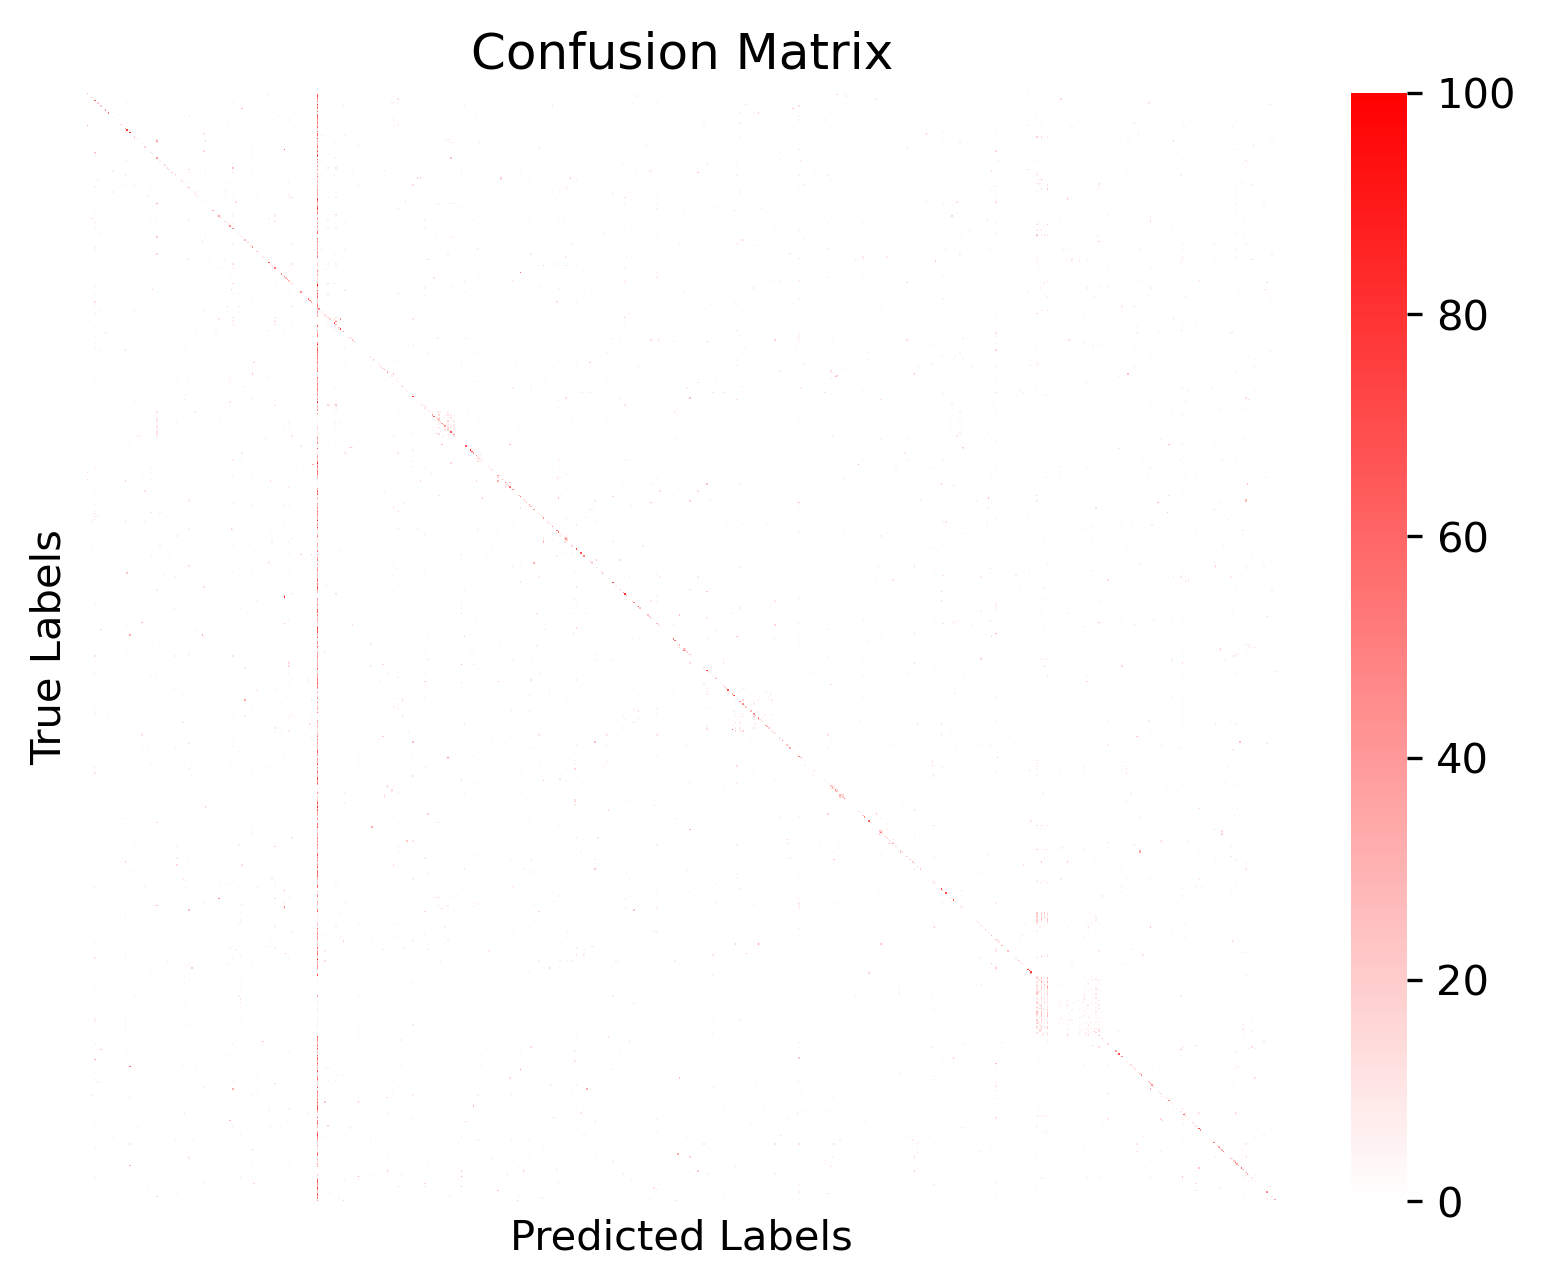

In [88]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix

target = s_latent
val_latent = target[target.obs['mode']=='val']
val_latent.obs.sort_values('pathway', inplace=True)

y_true = val_latent.obs.perturbation.astype(str)
y_pred = val_latent.obs.scanvi_predictions.str.split(';').str[-1]

u_y = y_true.unique()
y_true = pd.Categorical(y_true, categories=u_y)
y_pred = pd.Categorical(y_pred, categories=y_pred.unique())
# Select class labels
class_labels = pd.Categorical(u_y, categories=u_y)
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_labels)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


fig = plt.figure(dpi=300)

# Define a custom colormap from white to dodgerblue
white_to_blue = LinearSegmentedColormap.from_list(
    "white_to_blue",
    ["#ffffff", "red"]  # start at true white
)

# Plot the heatmap
sns.heatmap(
    cm_percentage,
    xticklabels=class_labels,
    yticklabels=class_labels,
    cmap=white_to_blue,
    vmin=0,
    vmax=100
)
plt.xlabel('Predicted Labels')
plt.xticks([])
plt.yticks([])
plt.ylabel('True Labels')
plt.title('Confusion Matrix')